In [34]:
import pandas as pd
import numpy as np
import networkx as nx
import ast
import pickle

In [35]:
# Load data from CSV
df = pd.read_csv('data/steam_cleaned_200.csv')

df.head()

,ID,name,price,label,release_date,developers,genre,platform,num_reviews,positive_review_rate
0,1966720,Lethal Company,9.99,Early Access;Online Co-Op;Horror;First-Person;...,2023-10-23,Zeekerss,"Action,Adventure,Indie,Early Access",['win'],44506,98
1,1172470,Apex Legends™,0.00,Free to Play;Battle Royale;Multiplayer;Shooter...,2020-11-04,Respawn Entertainment,"Action,Adventure,Free to Play",['win'],21286,70
2,730,Counter-Strike 2,145.82,FPS;Shooter;Multiplayer;Competitive;Action;Tea...,2012-08-21,Valve,"Action,Free to Play","['win', 'linux']",68565,71
3,1091500,Cyberpunk 2077,89.98,Cyberpunk;Open World;Nudity;RPG;Singleplayer;S...,2020-12-09,CD PROJEKT RED,RPG,['win'],10244,92
4,1174180,Red Dead Redemption 2,99.99,Open World;Story Rich;Western;Adventure;Action...,2019-12-05,Rockstar Games,"Action,Adventure",['win'],15436,94


In [66]:
# Create a new graph
G = nx.Graph()

# Add nodes and edges based on the CSV data
for index, row in df.iterrows():
    game_id = row['ID']
    game_name = row['name']
    developer = row['developers']
    genres = row['genre'].split(',')
    platforms = ast.literal_eval(row['platform'])
    num_reviews = row['num_reviews']
    positive_review_rate = row['positive_review_rate']

    # Add game node
    G.add_node(game_id, 
               type='game', 
               name=game_name, 
               price=row['price'], 
               release_date=row['release_date'], 
               developer=developer,
               genres=genres,
               platforms=platforms,
               num_reviews=num_reviews, positive_review_rate=positive_review_rate)

    # Add developer node and edge
    G.add_node(developer, type='developer')
    G.add_edge(game_id, developer)

    # Add genre nodes and edges
    for genre in genres:
        G.add_node(genre, type='genre')
        G.add_edge(game_id, genre)

    # Add platform nodes and edges
    for platform in platforms:
        G.add_node(platform, type='platform')
        G.add_edge(game_id, platform)

# Now your graph G is constructed with nodes and edges

# Save the graph into a pickle file
with open('data/graph.pickle', 'wb') as f:
    pickle.dump(G, f)


In [65]:
G.nodes(data=True)

NodeDataView({1966720: {'type': 'game', 'name': 'Lethal Company', 'price': 9.99, 'release_date': '2023-10-23', 'genres': ['Action', 'Adventure', 'Indie', 'Early Access'], 'platforms': ['win'], 'num_reviews': 44506, 'positive_review_rate': 98}, 'Zeekerss': {'type': 'developer'}, 'Action': {'type': 'genre'}, 'Adventure': {'type': 'genre'}, 'Indie': {'type': 'genre'}, 'Early Access': {'type': 'genre'}, 'win': {'type': 'platform'}, 1172470: {'type': 'game', 'name': 'Apex Legends™', 'price': 0.0, 'release_date': '2020-11-04', 'genres': ['Action', 'Adventure', 'Free to Play'], 'platforms': ['win'], 'num_reviews': 21286, 'positive_review_rate': 70}, 'Respawn Entertainment': {'type': 'developer'}, 'Free to Play': {'type': 'genre'}, 730: {'type': 'game', 'name': 'Counter-Strike 2', 'price': 145.82, 'release_date': '2012-08-21', 'genres': ['Action', 'Free to Play'], 'platforms': ['win', 'linux'], 'num_reviews': 68565, 'positive_review_rate': 71}, 'Valve': {'type': 'developer'}, 'linux': {'type':

In [67]:
len(G.nodes())

7062

In [38]:
G.has_node('Action')

True

In [39]:
if 'Action' in G:
    print('Yes')

Yes


In [40]:
genre_nodes = [
                node for node in G.neighbors(730) if G.nodes[node]["type"] == "genre"
            ]
genre_nodes

['Action', 'Free to Play']

In [41]:
# genre_name = [G.nodes[node]["name"] for node in genre_nodes]
for node in genre_nodes:
    print(G.nodes[node])

{'type': 'genre'}
{'type': 'genre'}


In [42]:
import matplotlib.pyplot as plt

def show_genre_distribution(G, selected_game_id):
    # Find similar games based on shared developers, genres, or platforms

    if selected_game_id not in G:
        print('Invalid game ID')
    similar_games = set()
    for node in G.neighbors(selected_game_id):
        if G.nodes[node]['type'] in ['developer', 'genre', 'platform']:
            similar_games.update(G.neighbors(node))
    
    # Count genres of similar games
    genre_count = {}
    for game_id in similar_games:
        if G.nodes[game_id]['type'] == 'game':
            for node in G.neighbors(game_id):
                if G.nodes[node]['type'] == 'genre':
                    genre_count[node] = genre_count.get(node, 0) + 1

    # Plot pie chart
    plt.figure(figsize=(8, 8))
    plt.pie(genre_count.values(), labels=genre_count.keys(), autopct='%1.1f%%')
    plt.title(f'Genre Distribution of Games Similar to {G.nodes[selected_game_id]["name"]}')
    plt.show()

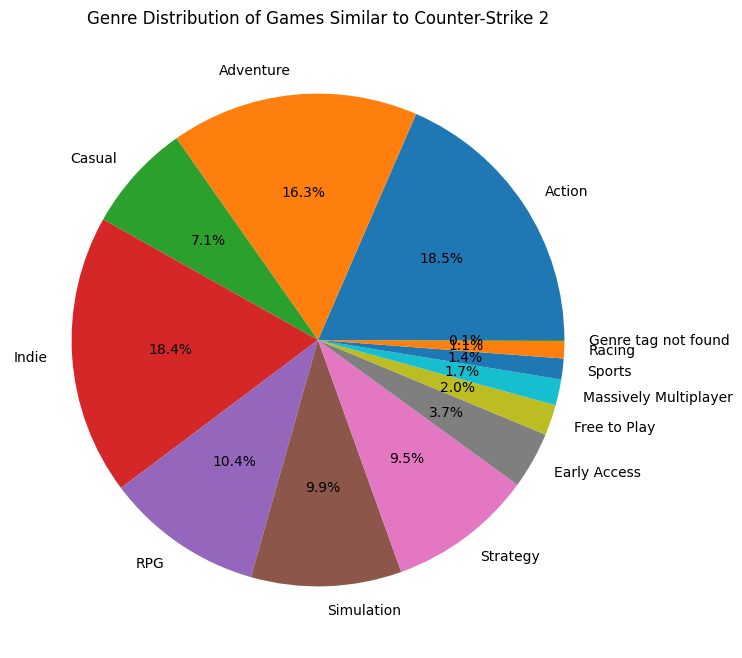

In [43]:
show_genre_distribution(G, 730)

In [44]:
def show_developer_connections(G, selected_game_id):
    subgraph_nodes = set([selected_game_id])
    for node in G.neighbors(selected_game_id):
        if G.nodes[node]['type'] == 'developer':
            subgraph_nodes.update(G.neighbors(node))

    subG = G.subgraph(subgraph_nodes)
    pos = nx.spring_layout(subG)
    nx.draw(subG, pos, with_labels=True, node_color='lightblue', edge_color='gray')
    plt.title(f'Developer Connections of {G.nodes[selected_game_id]["name"]}')
    plt.show()

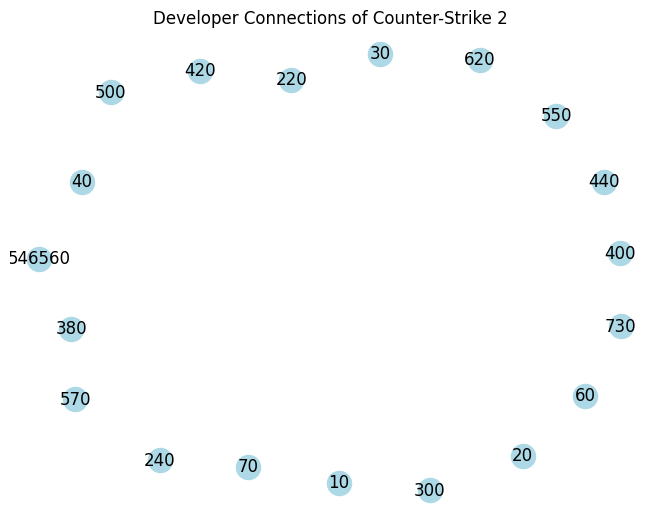

In [45]:
show_developer_connections(G, 730)

In [62]:
# Genre Evolution Over Time: Display a line graph showing the number of games in this genre released each year.



def show_genre_evolution(G, genre):
    # Find all games of the given genre
    genre_games = []
    for node in G.nodes:
        if G.nodes[node]['type'] == 'game':
            for neighbor in G.neighbors(node):
                if G.nodes[neighbor]['type'] == 'genre' and genre.lower() in neighbor.lower():
                        genre_games.append(node)
    
    # Count games released each year
    # release_date is in the format of 2023-10-23 type is datetime64
    year_count = {}
    for game_id in genre_games:
        year = G.nodes[game_id]['release_date'].split('-')[0]
        year_count[year] = year_count.get(year, 0) + 1
    
    # Sort by year with accending order
    year_count = dict(sorted(year_count.items(), key=lambda item: item[0]))
    
    # Plot line graph
    plt.figure(figsize=(8, 8))
    plt.plot(year_count.keys(), year_count.values())
    plt.title(f'Genre Evolution of {genre}')
    plt.xlabel('Year')
    plt.xticks(rotation=45)
    plt.ylabel('Number of Games')
    plt.show()

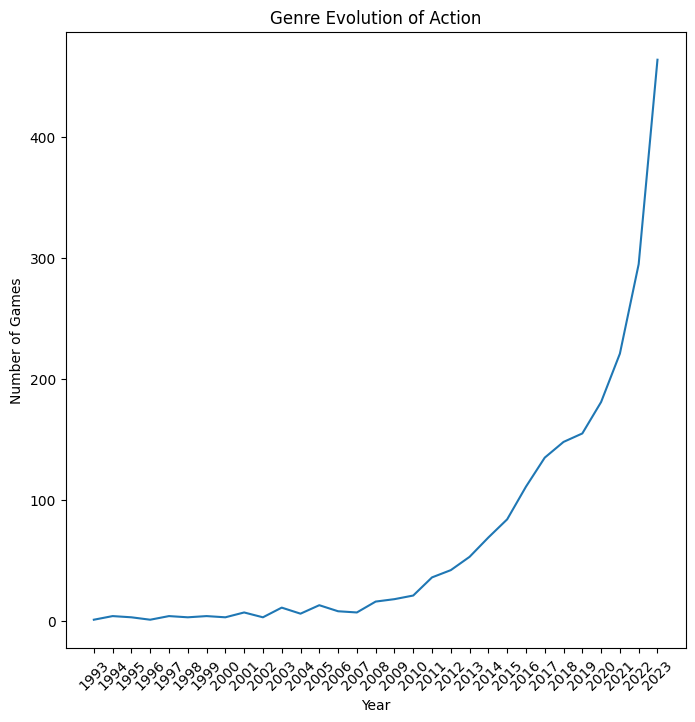

In [63]:
show_genre_evolution(G, 'Action')

In [68]:
# Popular Genres: Show a bar chart of the most popular genres on this platform.

def show_popular_genres(G, platform):
    # Find all games of the given platform
    platform_games = []
    for node in G.nodes:
        if G.nodes[node]['type'] == 'game':
            for neighbor in G.neighbors(node):
                if G.nodes[neighbor]['type'] == 'platform' and platform.lower() in neighbor.lower():
                        platform_games.append(node)
    
    # Count genres of games on this platform
    genre_count = {}
    for game_id in platform_games:
        for node in G.neighbors(game_id):
            if G.nodes[node]['type'] == 'genre':
                genre_count[node] = genre_count.get(node, 0) + 1
    
    # Sort by count with descending order
    genre_count = dict(sorted(genre_count.items(), key=lambda item: item[1], reverse=True))
    
    # Plot bar chart
    plt.figure(figsize=(8, 8))
    plt.bar(genre_count.keys(), genre_count.values())
    plt.title(f'Popular Genres on {platform}')
    plt.xlabel('Genre')
    plt.xticks(rotation=45)
    plt.ylabel('Number of Games')
    plt.show()

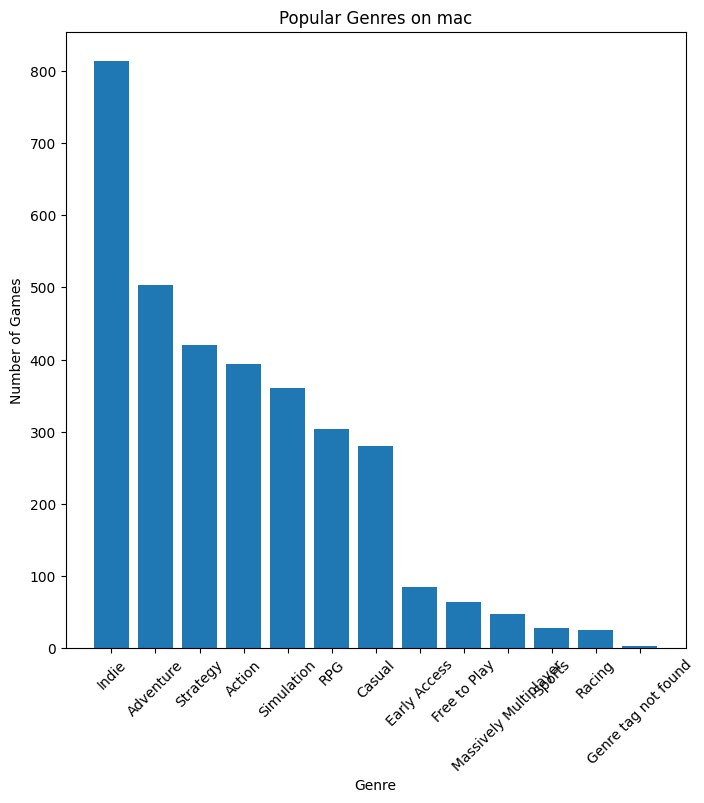

In [69]:
show_popular_genres(G, 'mac')

In [70]:
# Game Portfolio: Display all the games developed by this developer, along with key information.

def show_game_portfolio(G, developer):
    # Find all games of the given developer
    developer_games = []
    for node in G.nodes:
        if G.nodes[node]['type'] == 'game':
            for neighbor in G.neighbors(node):
                if G.nodes[neighbor]['type'] == 'developer' and developer.lower() in neighbor.lower():
                        developer_games.append(node)
    
    # Print game information
    for game_id in developer_games:
        game = G.nodes[game_id]
        print(f'Game ID: {game_id}')
        print(f'Game Name: {game["name"]}')
        print(f'Price: {game["price"]}')
        print(f'Release Date: {game["release_date"]}')
        print(f'Genres: {game["genres"]}')
        print(f'Platforms: {game["platforms"]}')
        print(f'Number of Reviews: {game["num_reviews"]}')
        print(f'Positive Review Rate: {game["positive_review_rate"]}')
        print()

In [71]:
show_game_portfolio(G, 'Valve')

Game ID: 730
Game Name: Counter-Strike 2
Price: 145.82
Release Date: 2012-08-21
Genres: ['Action', 'Free to Play']
Platforms: ['win', 'linux']
Number of Reviews: 68565
Positive Review Rate: 71

Game ID: 550
Game Name: Left 4 Dead 2
Price: 145.82
Release Date: 2009-11-16
Genres: ['Action']
Platforms: ['win', 'mac', 'linux']
Number of Reviews: 7694
Positive Review Rate: 97

Game ID: 570
Game Name: Dota 2
Price: 9.99
Release Date: 2013-07-09
Genres: ['Action', 'Strategy', 'Free to Play']
Platforms: ['win', 'mac', 'linux']
Number of Reviews: 30917
Positive Review Rate: 79

Game ID: 440
Game Name: Team Fortress 2
Price: 12.99
Release Date: 2007-10-10
Genres: ['Action', 'Free to Play']
Platforms: ['win', 'mac', 'linux']
Number of Reviews: 9858
Positive Review Rate: 94

Game ID: 546560
Game Name: Half-Life: Alyx
Price: 9.99
Release Date: 2020-03-23
Genres: ['Action', 'Adventure']
Platforms: ['win']
Number of Reviews: 713
Positive Review Rate: 97

Game ID: 500
Game Name: Left 4 Dead
Price: 59.

In [72]:
# Genre Expertise: Show a pie chart of the genre distribution of games developed by this developer.

def show_genre_expertise(G, developer):
    # Find all games of the given developer
    developer_games = []
    for node in G.nodes:
        if G.nodes[node]['type'] == 'game':
            for neighbor in G.neighbors(node):
                if G.nodes[neighbor]['type'] == 'developer' and developer.lower() in neighbor.lower():
                        developer_games.append(node)
    
    # Count genres of games developed by this developer
    genre_count = {}
    for game_id in developer_games:
        for node in G.neighbors(game_id):
            if G.nodes[node]['type'] == 'genre':
                genre_count[node] = genre_count.get(node, 0) + 1
    
    # Plot pie chart
    plt.figure(figsize=(8, 8))
    plt.pie(genre_count.values(), labels=genre_count.keys(), autopct='%1.1f%%')
    plt.title(f'Genre Distribution of Games Developed by {developer}')
    plt.show()

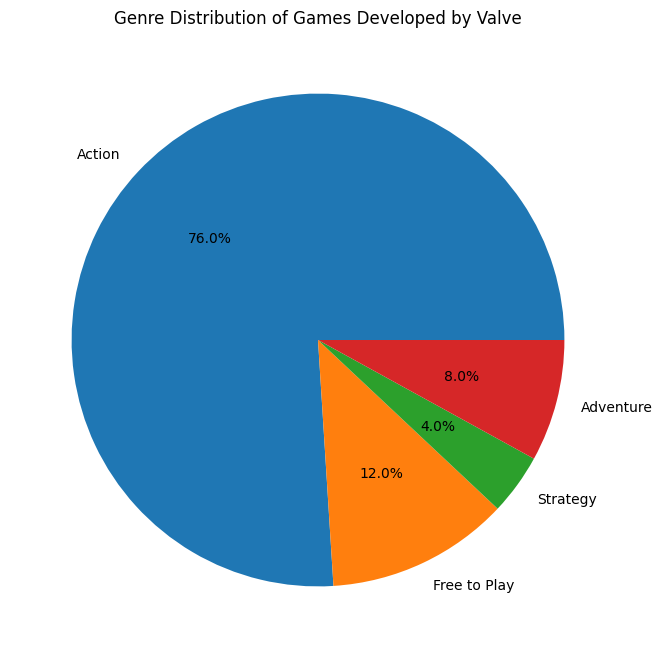

In [73]:
show_genre_expertise(G, 'Valve')